In [13]:
'''
Case study for paper: RFI ground source
'''
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
from contextlib import contextmanager
import xarray as xr
import matplotlib.colors as mcolors

@contextmanager
def cd(newdir):
    prevdir = os.getcwd()
    os.chdir(newdir)
    try:
        yield
    finally:
        os.chdir(prevdir)

model_path = '/edata2/spencer/rfi_prediction/GMI/GPM/'

file = '/pdata4/archive/GPM/1CR_GMI_V7/1403/140307/1C-R.GPM.GMI.XCAL2016-C.20140307-S165308-E182535.000125.V07A.HDF5'

with cd(model_path):
    import local_functions
    import model_operations
    import sensor_info
    data = local_functions.read_gmi_l1c(file)

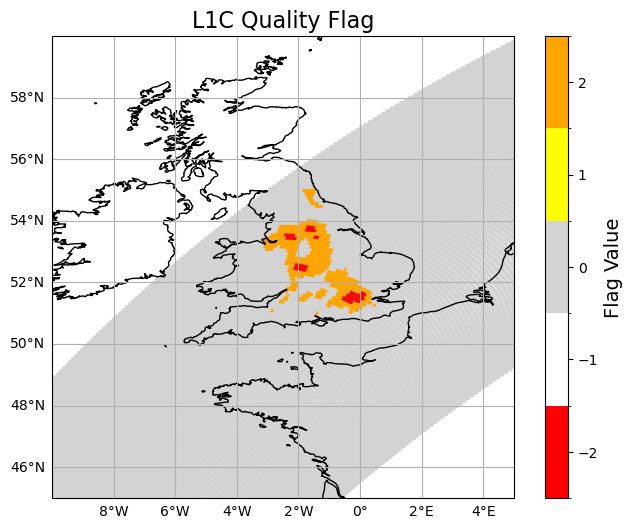

In [60]:
extent = [-10, 5, 45, 60]

colors = ['red', 'white', 'lightgray', 'yellow', 'orange']
cmap = mcolors.ListedColormap(colors)
bounds = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]
vals = [-2, -1, 0, 1, 2]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], data['lat'], c=data['qual'][:,:,0], 
                transform=ccrs.PlateCarree(), s=5.,
                cmap=cmap, norm=norm)
plt.title('L1C Quality Flag', fontsize=16)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_extent(extent)

cb = plt.colorbar(mappable=im, shrink=1, ticks=vals)
cb.set_label('Flag Value', fontsize=14)


plt.show()

In [57]:
error_threshold = 5

nscans, npixs = data['lat'].shape

with cd(model_path):
    model_tree = model_operations.load_model_tree()
    sfctype = local_functions.attach_gpm_sfctype(data['lat'], data['lon'], data['scantime'], sensor='GMI')
    Tbs_pred = model_operations.run_predictions(data['Tbs'], sfctype, model_tree)
    mean_ocn = np.fromfile('mean_ocn.arr', sep='', dtype=np.float32)
    std_ocn  = np.fromfile('std_ocn.arr', sep='', dtype=np.float32)
    mean_non = np.fromfile('mean_non.arr', sep='', dtype=np.float32)
    std_non  = np.fromfile('std_non.arr', sep='', dtype=np.float32)


epsilon_hat = np.zeros_like(Tbs_pred)
ocean = sfctype == 1
ocean = ocean.reshape(nscans,npixs)
nonocean = sfctype > 1
nonocean = nonocean.reshape(nscans,npixs)
epsilon = data['Tbs'] - Tbs_pred
epsilon_hat[ocean] = np.abs(epsilon[ocean] - mean_ocn) / std_ocn
epsilon_hat[nonocean] = np.abs(epsilon[nonocean] - mean_non) / std_non
mlflag = np.zeros(data['Tbs'].shape, dtype=np.int32)
mlflag[epsilon_hat > error_threshold] = 1

In [58]:
mlflag[np.isnan(epsilon_hat)] = -2

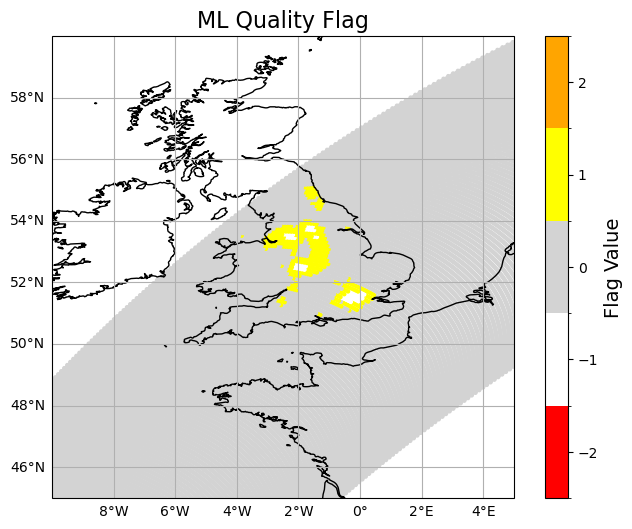

In [67]:
chan = ['10H']

colors = ['red', 'white', 'lightgray', 'yellow', 'orange']
cmap = mcolors.ListedColormap(colors)
bounds = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]
vals = [-2, -1, 0, 1, 2]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

chan_desc = np.array(sensor_info.channel_descriptions)
chan_indx = np.where(chan == chan_desc)[0]

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], data['lat'], c=mlflag[:,:,chan_indx], 
                transform=ccrs.PlateCarree(), s=5.,
                cmap=cmap, norm=norm)
plt.title('ML Quality Flag', fontsize=16)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_extent(extent)

cb = plt.colorbar(mappable=im, shrink=1., ticks=vals)
cb.set_label('Flag Value', fontsize=14)

plt.show()

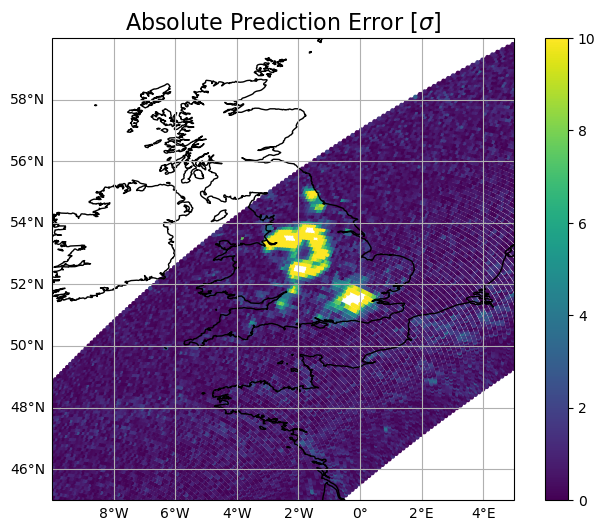

In [69]:
chan = ['10H']

chan_desc = np.array(sensor_info.channel_descriptions)
chan_indx = np.where(chan == chan_desc)[0]

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax.scatter(data['lon'], data['lat'], c=epsilon_hat[:,:,chan_indx], 
                transform=ccrs.PlateCarree(), s=5.,
                vmin=0, vmax=10,
                cmap='viridis')
plt.title('Absolute Prediction Error [$\\sigma$]', fontsize=16)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.set_extent(extent)

cb = plt.colorbar(mappable=im, shrink=1.)

plt.show()